## Supervisor agent (tutorial)



This notebook uses supervisor agent implementation from Langgraph. It calls either Researcher (to return web search results) or Coder (to perform calculations)

In [ ]:
from typing import Literal

from langchain.chat_models import init_chat_model

# from langchain_anthropic import ChatAnthropic
from langgraph.graph import END, MessagesState
from langgraph.types import Command
from typing_extensions import TypedDict

# members = ["researcher", "coder"]
members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = [*members, "FINISH"]

In [2]:
system_prompt = """You are a supervisor agent responsible for coordinating between a researcher agent and a coder agent.
Given the following user request, respond with the agent to act next. Each agent will perform a task and respond with their results and status. When finished, respond with FINISH.

You should follow these steps:

1. Analyze user queries as well as conversation history and determine if agent(s) should handle the request
2. Write out your reasoning and analysis of how to route this request and determine which agent(s) should handle the request
3. Route requests to the appropriate agent(s)
4. Evaluate whether previous message fully answers the user query, without explicitely providing instructions to find the results.
5. If the user query was fully answered without explicitely providing instructions to find the results:
     return: FINISH
6. If user query was not fully answered, repeat previous steps.

Guidelines for request handling:

1. if the request requires web search:
   - return: researcher

2. if the request requires performing mathematical operations:
   - return: coder

3. if the request has a complete answer in the conversation history without explicitely providing instructions to find the results:
   - return: FINISH

"""

In [ ]:
llm = init_chat_model(model="anthropic.claude-3-sonnet-20240229-v1:0", model_provider="bedrock")

In [ ]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)  # llm_openai give better response
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

FINISH: Returns the final response to the user

In [5]:
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b


def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the different headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

In [6]:
RESEARCH_PROMPT = """You are a researcher. Your task is to search the web using the available tools.
<guidelines>
Only return the results from the web search
Do not alter or summarise the responses returned by the web search
Do not perform mathematical operations
</guidelines>
"""

RESEARCH_PROMPT = """You are a researcher. Your task is to search the web using the available tools.

Guidelines for request handling:

1. Do not perform mathematical operations

"""

In [7]:
CODE_PROMPT = """You are a coder. Your task is to perform mathematical operations using the available tools.
"""

In [8]:
from langchain_core.messages import HumanMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(llm, tools=[web_search], prompt=RESEARCH_PROMPT, name="researcher")


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="researcher")]},
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[add, multiply], prompt=CODE_PROMPT, name="coder")


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="coder")]},
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

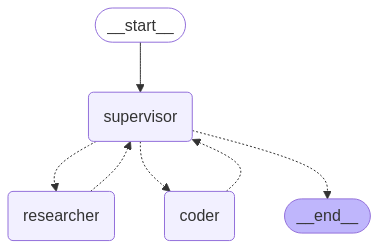

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
for _s in graph.stream(
    {"messages": [("user", "what's the combined headcount of the FAANG companies in 2024?")]}, subgraphs=True
):
    pass

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:cc7b4f06-ece1-9fbd-70fc-f8a29ea80942',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YeNRo805CadBI500zUlOfL8N', 'function': {'arguments': '{"query":"FAANG companies combined headcount 2024"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 113, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'id': 'chatcmpl-BH8R5UtE0FbHVQN3hb9QmU0sA0bbM', 'finish_reason': 'tool_calls', 'logprobs': None}, name='researcher', id='run-d9d100cb-7fce-4a1d-ad16-283f6e7b46a7-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'FAANG companies combine